# Project: Time Series - Forecasting the number of Air Passengers<br>
by Adam M. Lang<br>
November 26, 2020<br>

----
## Context: 
-------

This dataset provides monthly totals of a US airline passengers (in thousands) from the period of 1949 to 1960. This dataset is taken from an inbuilt dataset of R called AirPassengers.

---------
## Objective:
------------
You are a data scientist for this airline and they want to forecast the monthly number of passengers for the next 24 months (i.e for the period of 1961-1962) to balance their manpower hiring and decision on the additional/alteration in the existing and new routes. This forecast will also help the airline to set their dynamic pricing according to the need.

--------
## Attributes Information:
------------
- 'Year-Month' ----> Month and Year starting from 01-01-1949
- '# Passengers' ----> Total number of passengers for a particular month

---------------------------


### Import libraries

In [1]:
# Install this to upgrade the statsmodels package. It will be required to use AR, MA, & ARMA models
!pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in c:\users\pytho\anaconda3\lib\site-packages (0.12.1)


In [78]:
# To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [79]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

#Importing library for date manipulation
from datetime import datetime

### Reading the dataset

In [80]:
# Mount your drive if you are using Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

In [81]:
#Reading the dataset
df = pd.read_excel('AirPassenger.xlsx')
df.head()

,Year-Month,# Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [82]:
#Check the shape of the dataset
df.shape

(144, 2)

In [83]:
#Setting the date as an index to make the dataset with only one column

df['Year-Month'] = pd.to_datetime(df['Year-Month'], infer_datetime_format=True)
df = df.set_index(['Year-Month'])
df.head()

,# Passengers
Year-Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [84]:
#check tail of dataframe
df.tail()

,# Passengers
Year-Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


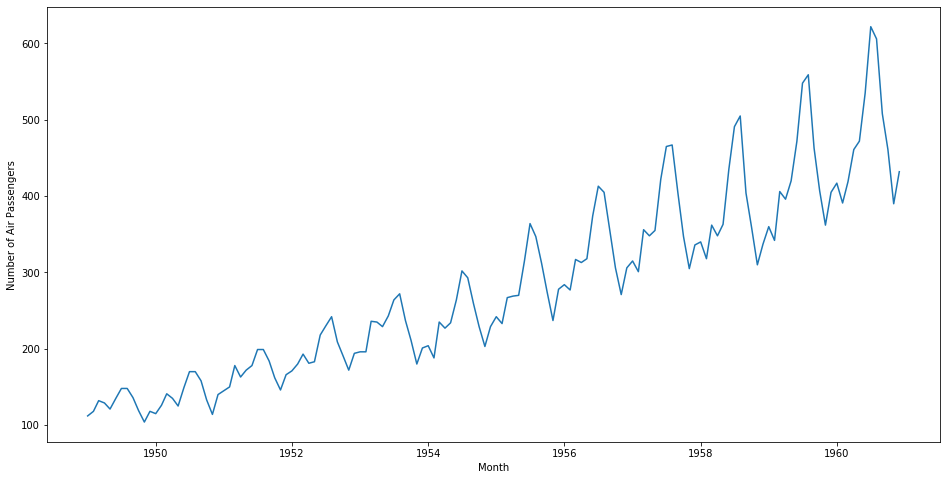

In [85]:
# Visualizing the time series dataset
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Number of Air Passengers")
plt.plot(df);

**Observations**
- We can see that the series has a upward trend with some seasonality
- Before modelling with AR, MA or ARMA, we need to check whether the series is stationary or not
- Let us first check the rolling mean and standard deviation of the series if we can visualize any trend or seasonality

### Calculating and Visualizing the rolling mean & standard deviation of the series (for 12 observations) to check the stationarity of the time series

In [86]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df.rolling(window=12).mean()    #calculate the mean here
rolstd=df.rolling(window=12).std()     #calculate the standard deviation here
print(rolmean.head(15))
print('**************************************')
print('**************************************')
print(rolstd.head(15))

            # Passengers
Year-Month              
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01           NaN
1949-08-01           NaN
1949-09-01           NaN
1949-10-01           NaN
1949-11-01           NaN
1949-12-01    126.666667
1950-01-01    126.916667
1950-02-01    127.583333
1950-03-01    128.333333
**************************************
**************************************
            # Passengers
Year-Month              
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01           NaN
1949-08-01           NaN
1949-09-01           NaN
1949-10-01           NaN
1949-11-01           NaN
1949-12-01     13.720147
1950-01-01     13.453342
1950-02-01     13.166475
1950-03-01     13.686977


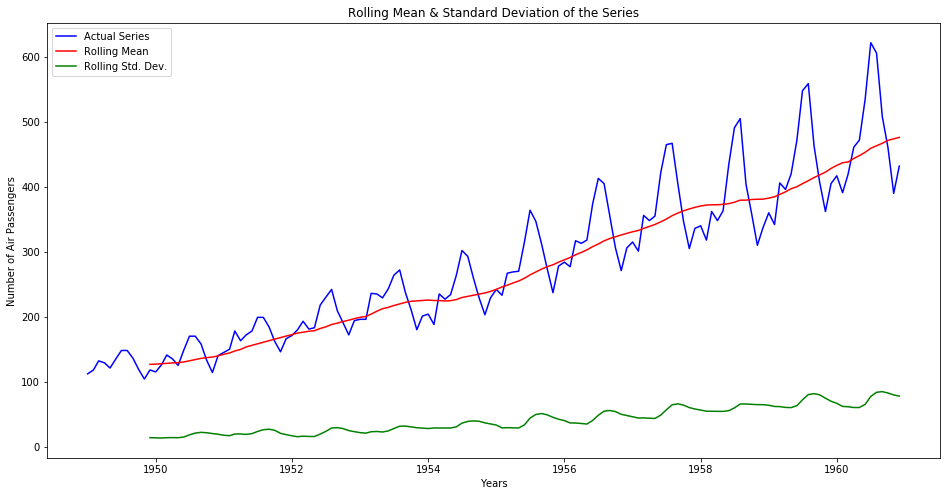

In [87]:
#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df, color='blue', label='Actual Series')     #fill the dataframe name
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean')    #fill the dataframe name 
rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')   #fill the dataframe name
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.xlabel('Years')
plt.ylabel('Number of Air Passengers')
plt.legend()
plt.show()

**Observations:**
* We can see the upward trend in the number of passengers per year starting around 100 in 1949 and going up to a peak of above 600 in the 1960's. 
* Since the mean and standard deviation are always changing we can thus confirm that this time series is NOT stationary. 

### Testing the stationarity of the series using Augmented Dickey-Fuller Test

The hypotheses for ADF test are defined as 
-        Null hypothesis         - Time Series is non-stationary
-        Alternative hypothesis  - Time Series is stationary

In [88]:
#Define a function to use adfuller test
def adfuller(df):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df['# Passengers'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df)

Dickey-Fuller Test: 
Test Statistic            0.815369
p-value                   0.991880
Lags Used                13.000000
No. of Observations     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


**Observations**
1. From the above test, we see that the p-value = 0.991880 i.e. > 0.1 (For 90% confidence intervals) therefore, we fail to reject the null hypothesis.
2. Hence, we can confirm that the series is non-stationary

### Making the series stationary

We can use the following methods to make a non-stationary series to stationary.
1. Log transformation
2. Differencing
3. By shifting the series (lagged series)

Let's first use the log transfromation over this series to remove exponential variance and again check the stationarity of the series

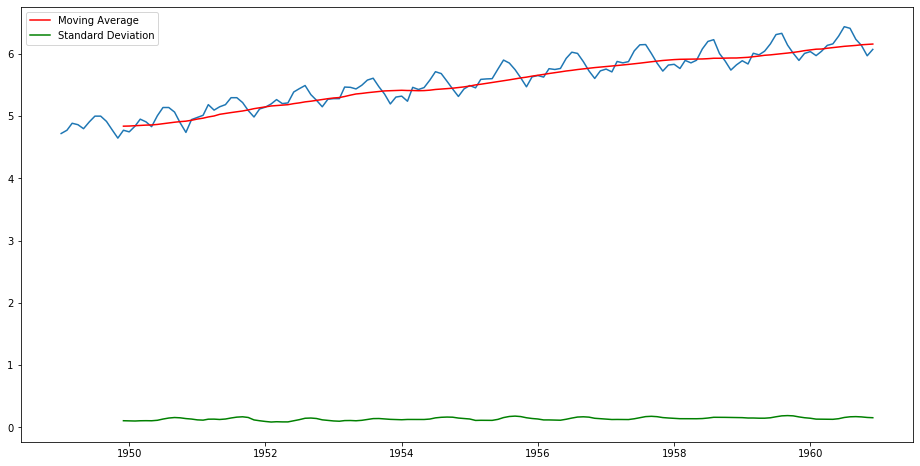

In [90]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df)
MAvg = df_log.rolling(window=12).mean()   #calculate the mean
MStd = df_log.rolling(window=12).std()   #calculate the standard deviation
plt.plot(df_log)                            #plot the dataframe with log transformation
plt.plot(MAvg, color='r', label = 'Moving Average')   #plot the moving average of the dataframe with log transformation
plt.plot(MStd, color='g', label = 'Standard Deviation')   #plot the standard deviation of the dataframe with log transformation
plt.legend()
plt.show()

**Observations:**
* The log transformation made the mean more steady, and the standard deviation is also more steady, however both are still changing and moving upwards so we have not achieved full stationarity. 

Let's use differencing method over the series to remove temporal dependence (trend) and again check the stationarity of the series

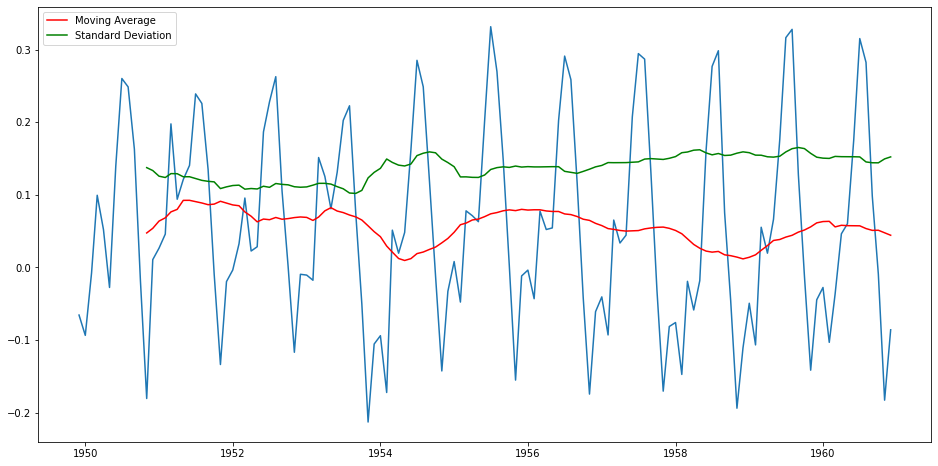

In [91]:
# Visualize the rolling mean and standard deviation after using log transform and differencing 
plt.figure(figsize=(16,8))
df_log_diff = df_log - MAvg
MAvg_diff = df_log_diff.rolling(window=12).mean()    #calculate the mean
MStd_diff = df_log_diff.rolling(window=12).std()    #calculate the standard deviation
plt.plot(df_log_diff)                                     #plot the dataframe with differencing
plt.plot(MAvg_diff, color='r', label = 'Moving Average')  #plot the moving average of the dataframe with differencing
plt.plot(MStd_diff, color='g', label = 'Standard Deviation') #plot the standard deviation of the dataframe with differencing
plt.legend()
plt.show()

#Dropping the null values that we get after applying diffrencing method
df_log_diff = df_log_diff.dropna()

**Observations:**
* The mean and standard deviation seem to be more constant over time. We appear to have achieved stationarity. Let's check the adfuller test to confirm these results. 

In [92]:
#Using the adfuller function for df_log_diff
adfuller(df_log_diff)

Dickey-Fuller Test: 
Test Statistic           -3.162908
p-value                   0.022235
Lags Used                13.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
* The p-value is 0.022 which is less than 0.05 so we can successfully reject the null hypothesis that the data is non-stationary and accept the alternative hypothesis that the data now has stationarity to it. 

Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series) and then check the rolling mean and standard deviation

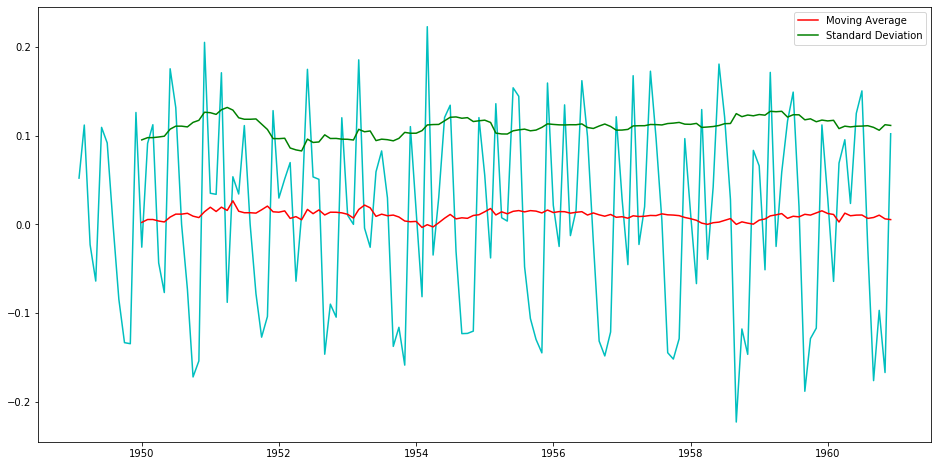

In [93]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()   #calculate the mean
MStd_shift = df_shift.rolling(window=12).std()   #calculate the standard deviation
plt.plot(df_shift, color='c')                       #plot the dataframe with lag
plt.plot(MAvg_shift, color='red', label = 'Moving Average')    #plot the moving average of the dataframe with lag
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')    #plot the standard deviation of the dataframe with lag
plt.legend()
plt.show()

#Dropping the null values that we get after applying diffrencing method
df_shift = df_shift.dropna()

**Observations:**
* By shifting the series by order 1 (1 month), and applying differencing (using lagged series) we were able to refine the stationarity and the mean and standard deviation are now much smoother. We should check the adfuller hypothesis test to confirm there is stationarity improvement. 

In [94]:
#Using the adfuller function for df_shift
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic           -2.717131
p-value                   0.071121
Lags Used                14.000000
No. of Observations     128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


**Observations:**
* The p-value is still significant at 0.07 which is close to the significance level of 0.05 so we can reject the null hypothesis and based upon the finding of the adfuller test and the graphical finding we can say we have achieved stationarity. 

**Note:** *We will use the lag 1 series (df_shift) for AR, MA & ARMA models.*

### Decomposing the time series components into Trend, Seasonality and Residual

Let us decompose the time series to separate the components of the time series

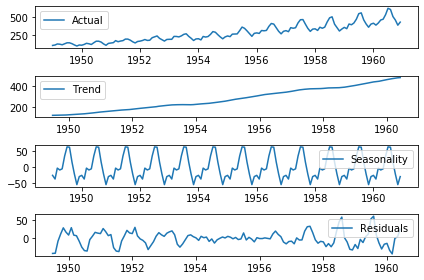

In [95]:
#Importing the seasonal_decompose to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df)      #Use the actual series to decompose

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.subplot(411)
plt.plot(df, label='Actual')
plt.legend()
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend()
plt.tight_layout()

**Observations:**
* We can see there is a significant Trend, Seasonality, and Residuals components within the Time-Series. 
* The Trend is directly linear and increases yearly with a steady slope following the Actual Time-Series.  
* Seasonality has an oscillating peaks and troughs with the high occurring for example between 1950 and 1951, the low occurs at 1951 and then it rises again between 1951 and 1952. The trend repeats it self for every year after that. 
* The Residuals start off with steady up and down trend and then appear to achieve stationarity between 1954 and 1956 before going back to the up and down trend. 

### Plotting the auto-correlation function and partial auto-correlation function to get p and q value for AR, MA and ARMA models

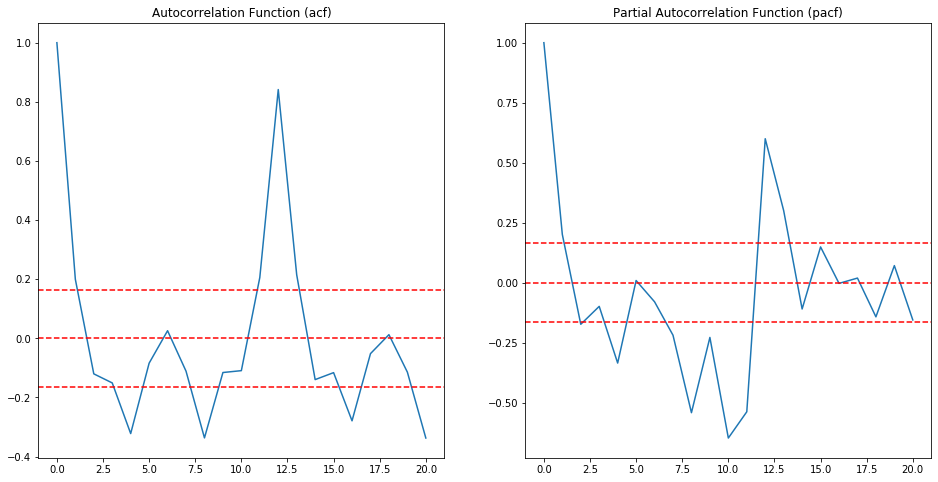

In [96]:
#Importing acf and pacf functions
from statsmodels.tsa.stattools import acf, pacf
#Using 20 lags in the series
lag_acf = acf(df_shift, nlags=20,fft=False)
lag_pacf = pacf(df_shift, nlags=20, method='ols')

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.title('Autocorrelation Function (acf)')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.title('Partial Autocorrelation Function (pacf)')
plt.show()

**Observations**
- We can see that in both plots, the blue line is entering into the confidence interval (dotted red) at 2, therefore we will be using the values of p, q values as 2

### AR Model

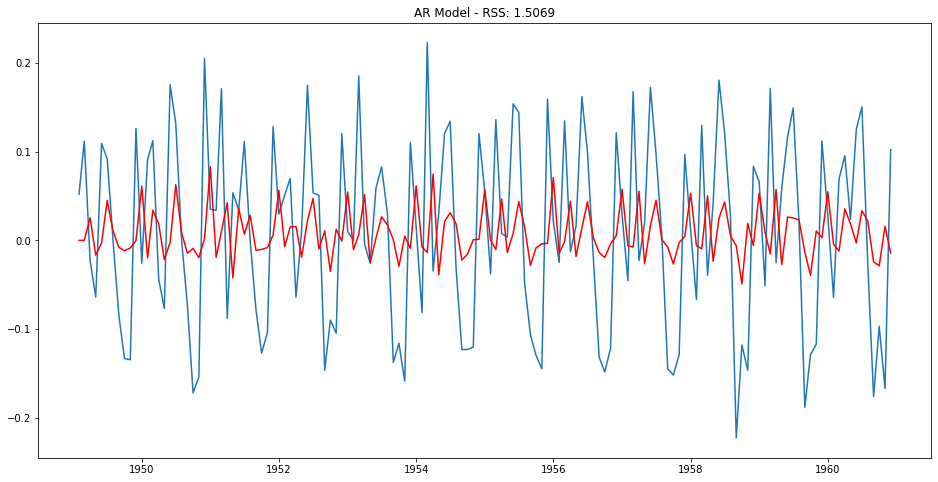

In [97]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

#Comparing the actual & predicted series by AR model and calculating the Residual Sum of Squares
plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=2) #Using number of lags as 2
results_AR = model_AR.fit()
plt.plot(df_shift)   #Visualizing the actual series used for modelling
predict = results_AR.predict(start=0,end=len(df_shift)-1)
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RSS: %.4f'% sum((predict-df_shift['# Passengers'])**2))   #calculate the residual sum of squares
plt.show()

**Observations**
- We can see that by using AR model, we get RSS = 1.5069
- Let us use MA and ARMA models and see if we can reduce the RSS

### MA Model

We will be using ARMA model with p=0 so that it will work as MA Model

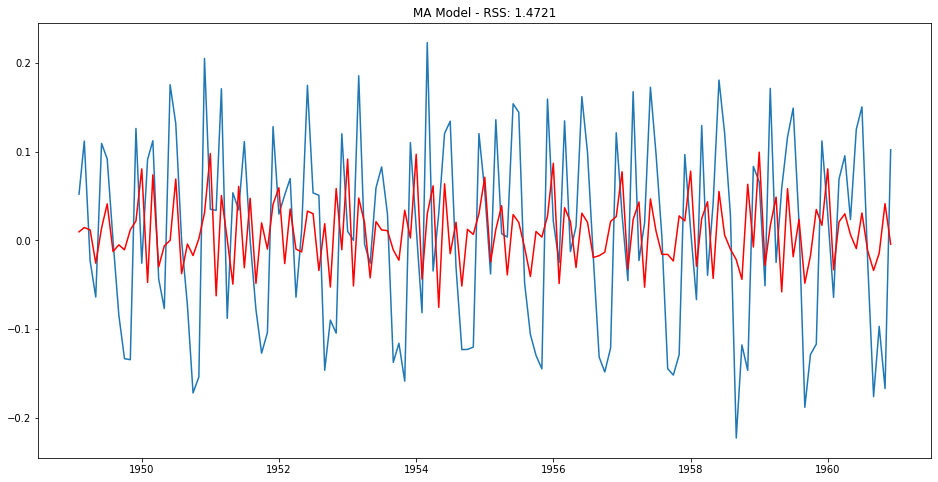

In [98]:
#Importing ARMA
from statsmodels.tsa.arima_model import ARMA

#Comparing the actual & predicted series by MA model and calculating the Residual Sum of Squares
plt.figure(figsize=(16,8))
model_MA = ARMA(df_shift, order=(0,2)) #Using p=0 and q=2
results_MA = model_MA.fit()
plt.plot(df_shift)              #Visualzing the actual series used for modelling
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model - RSS: %.4f'% sum((results_MA.fittedvalues-df_shift['# Passengers'])**2))    #calculate the residual sum of squares
plt.show()

**Observations**
- We can see that by using MA model, we get RSS = 1.4721, which is less than AR model which was 1.5069.
- Let us use ARMA model and see if we can reduce the RSS

### ARMA Model

We will using p=2 and q=2 as inferred from acf and pacf

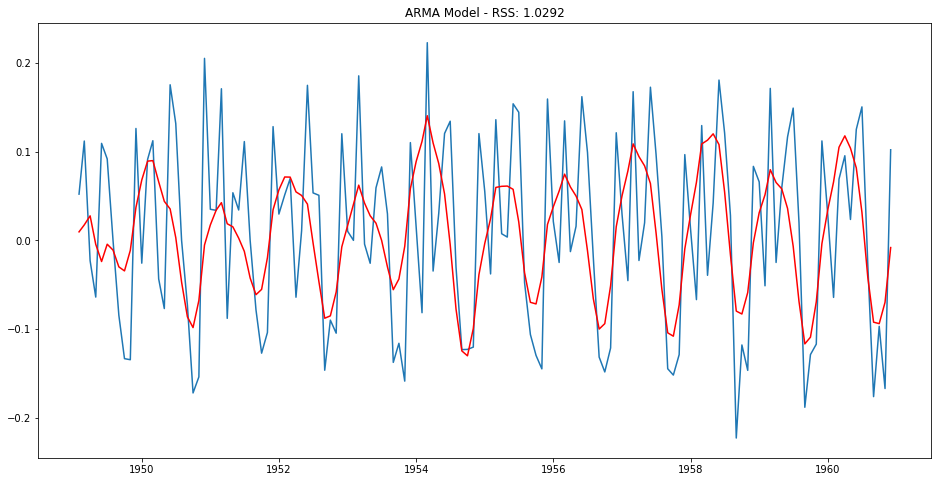

In [99]:
from statsmodels.tsa.arima_model import ARMA

#Comparing the actual & predicted series by AR model and calculating the Residual Sum of Squares
plt.figure(figsize=(16,8))
model = ARMA(df_shift, order=(2,2)) #Using p=2, q=2
results = model.fit()
plt.plot(df_shift)            #Visualizing the actual series used for modelling
plt.plot(results.fittedvalues, color='red')
plt.title('ARMA Model - RSS: %.4f'% sum((results.fittedvalues-df_shift['# Passengers'])**2))   #calculate the residual sum of squares
plt.show()  

In [100]:
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:           # Passengers   No. Observations:                  143
Model:                     ARMA(2, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Thu, 26 Nov 2020   AIC                           -287.281
Time:                        08:41:50   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.# Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.# Passengers  

In [101]:
#Printing the fitted values
predictions=pd.Series(results.fittedvalues)
predictions

Year-Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
                ...   
1960-08-01   -0.041176
1960-09-01   -0.092350
1960-10-01   -0.094013
1960-11-01   -0.069924
1960-12-01   -0.008127
Length: 143, dtype: float64

**Observations:**
- We can see that by using ARMA model, we get RSS = 1.0292, which is lesser than both AR and MA models.
- Since ARMA model gives us the best RSS, we will forecast the values using ARMA.

### Inverse Transformation 

Since we now have the fitted values by ARMA model, we will use the inverse transformation to get the original values.

In [102]:
#First step - doing cumulative sum
predictions_cumsum = predictions.cumsum()    #Use the predicted values series
predictions_cumsum

Year-Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372553
1960-09-01    1.280203
1960-10-01    1.186190
1960-11-01    1.116266
1960-12-01    1.108139
Length: 143, dtype: float64

In [103]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['# Passengers'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)   #Use the series with cumulative sum
predictions_log

Year-Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
                ...   
1960-08-01    6.091052
1960-09-01    5.998702
1960-10-01    5.904689
1960-11-01    5.834765
1960-12-01    5.826638
Length: 144, dtype: float64

In [104]:
#Third step - applying exponential transformation
predictions_ARMA = np.exp(predictions_log)       #Use the series with log values
predictions_ARMA

Year-Month
1949-01-01    112.000000
1949-02-01    113.078122
1949-03-01    115.073416
1949-04-01    118.301994
1949-05-01    117.768372
                 ...    
1960-08-01    441.885901
1960-09-01    402.905411
1960-10-01    366.753015
1960-11-01    341.984305
1960-12-01    339.216259
Length: 144, dtype: float64

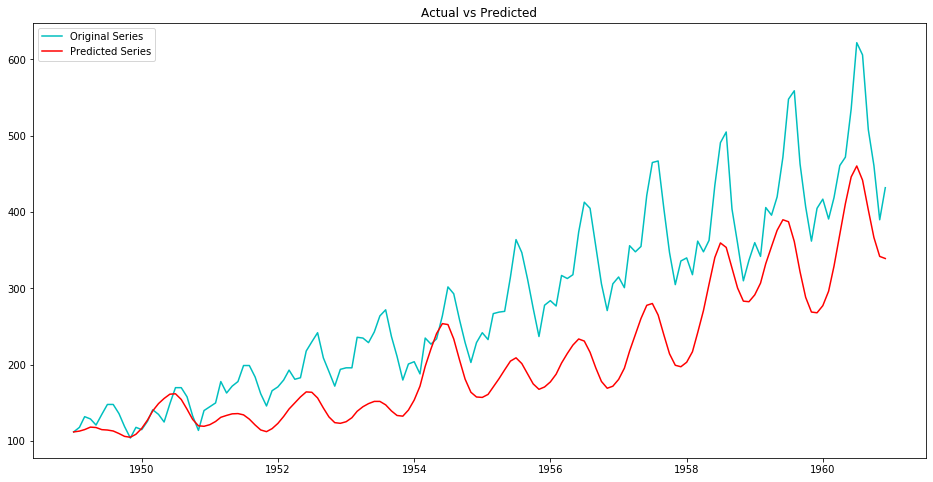

In [105]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df, color = 'c', label = 'Original Series')
plt.plot(predictions_ARMA, color = 'r', label = 'Predicted Series')       #Use the series with predicted values
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations**
- We can see that the predicted series is very similar to that of original series
- Let us forecast the number of passengers for next 24 months

### Forecasting the number of passengers for next 24 months

In order to forecast the values for next 24 months, we need to follow the below steps-
1. Forecast the fitted values for next 24 months
2. Make a combined list containing the previous fitted values by ARMA model (1949-1960 and these 24 months (1961-1962) forecasted values
3. Convert that combined list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 01-01-1949 to 12-01-1962 as the index and the respective predicted cumulative sum values
5. Add the log values of the original series in the same dataframe from 1949-1960 and 1961-1962 as NaN (since we don't know the original number of passengers for this period)
6. Applying the inverse tranformation and get the forecasted number of passengers

In [106]:
#Forecasting the values for next 24 months
predictions_ARMA = results.forecast(steps=24) # here steps represent the number of months
predictions_ARMA[0]

array([ 0.02710821,  0.05728002,  0.07161562,  0.06798141,  0.04923625,
        0.02194656, -0.00574668, -0.02645378, -0.03541767, -0.03149834,
       -0.01709398,  0.00286836,  0.02250658,  0.03664475,  0.04211185,
        0.03837169,  0.02738734,  0.0128368 , -0.00104361, -0.01064202,
       -0.01386339, -0.01052547, -0.00220541,  0.00836415])

In [107]:
#Converting the fitted values by ARMA into a list
predictions_list = predictions.tolist()
#Converting the forecasted values by ARMA into a list
predictions_ARMA_list = predictions_ARMA[0].tolist()
#combining the both lists
predictions_list.extend(predictions_ARMA_list)
predictions_list

[0.009580052442695691,
 0.01749140239008705,
 0.02767030291031014,
 -0.004520881488907294,
 -0.023889545744452123,
 -0.004346850713222772,
 -0.010977546030222728,
 -0.02992889814238428,
 -0.03446732201840366,
 -0.011278596387955392,
 0.03721205817265898,
 0.06813483367612069,
 0.0894339917266661,
 0.090029250807908,
 0.06615175942804138,
 0.04405337304189494,
 0.03546711902438293,
 0.0031001866578431736,
 -0.04712733212730613,
 -0.08635279511120786,
 -0.09846511601712904,
 -0.06784623252372582,
 -0.0052275188339492296,
 0.017384825054500203,
 0.03401563622239434,
 0.04256129360849725,
 0.01874768370223387,
 0.015259935092950962,
 0.0024892337556579533,
 -0.012407975288045242,
 -0.042491863987825104,
 -0.06132792260473677,
 -0.055338030039713076,
 -0.0195704678240905,
 0.03455550350132233,
 0.0569752901752158,
 0.07153405564906466,
 0.07139122507558149,
 0.05474120619345861,
 0.05066200664623868,
 0.040927837145520035,
 -0.002985970479032228,
 -0.04648270237077387,
 -0.08789652865946834

In [108]:
#Converting the combined list into a series
predictions_list_series = pd.Series(predictions_list)
predictions_list_series

0      0.009580
1      0.017491
2      0.027670
3     -0.004521
4     -0.023890
         ...   
162   -0.010642
163   -0.013863
164   -0.010525
165   -0.002205
166    0.008364
Length: 167, dtype: float64

In [109]:
forecasted_cumsum = predictions_list_series.cumsum()
forecasted_cumsum

0      0.009580
1      0.027071
2      0.054742
3      0.050221
4      0.026331
         ...   
162    1.458138
163    1.444275
164    1.433749
165    1.431544
166    1.439908
Length: 167, dtype: float64

In [110]:
#Making a new dataframe to get the additional dates from 1961-1962
index = pd.date_range('1949-02-01','1963-01-01' , freq='1M') - pd.offsets.MonthBegin(1)
df_final = pd.DataFrame()
df_final['Forecasted cumsum'] = forecasted_cumsum
df_final.index = index
df_final 

,Forecasted cumsum
1949-02-01,0.009580
1949-03-01,0.027071
1949-04-01,0.054742
1949-05-01,0.050221
1949-06-01,0.026331
...,...
1962-08-01,1.458138
1962-09-01,1.444275
1962-10-01,1.433749
1962-11-01,1.431544


In [111]:
#Joining the forecasted cum sum values to that with original log series
df_final = df_final.join(df_log, lsuffix='cumsum')
df_final
#The last NaN values show the absence of the original values

,Forecasted cumsum,# Passengers
1949-02-01,0.009580,4.770685
1949-03-01,0.027071,4.882802
1949-04-01,0.054742,4.859812
1949-05-01,0.050221,4.795791
1949-06-01,0.026331,4.905275
...,...,...
1962-08-01,1.458138,NaN
1962-09-01,1.444275,NaN
1962-10-01,1.433749,NaN
1962-11-01,1.431544,NaN


In [112]:
#Adding the first value to the cum sum values
forecasted_log = pd.Series(df_final['# Passengers'].iloc[0], index = df_final.index)
forecasted_log = forecasted_log.add(df_final['Forecasted cumsum'])
forecasted_log 

1949-02-01    4.780265
1949-03-01    4.797756
1949-04-01    4.825426
1949-05-01    4.820906
1949-06-01    4.797016
                ...   
1962-08-01    6.228823
1962-09-01    6.214960
1962-10-01    6.204434
1962-11-01    6.202229
1962-12-01    6.210593
Freq: M, Length: 167, dtype: float64

In [113]:
#Applying exponential transformation to the forecasted log values
forecasted_ARMA = np.exp(forecasted_log)
forecasted_ARMA

1949-02-01    119.135878
1949-03-01    121.238063
1949-04-01    124.639601
1949-05-01    124.077392
1949-06-01    121.148365
                 ...    
1962-08-01    507.158180
1962-09-01    500.175760
1962-10-01    494.938784
1962-11-01    493.848446
1962-12-01    497.996391
Freq: M, Length: 167, dtype: float64

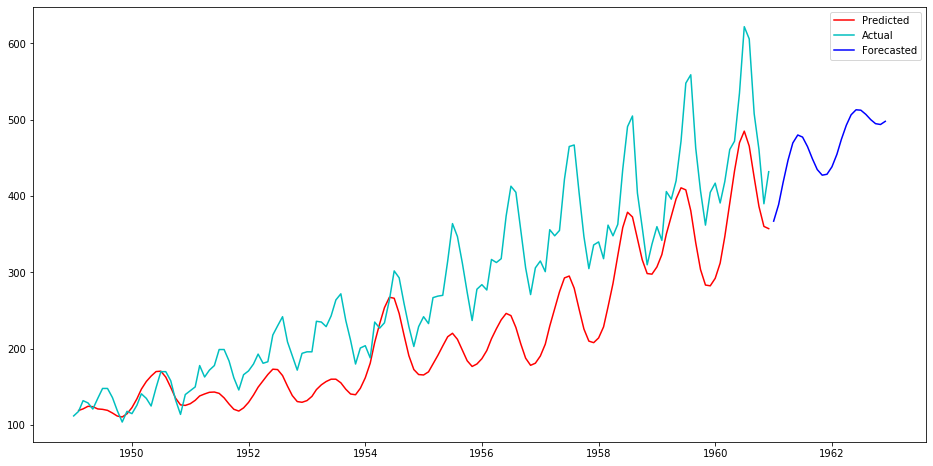

In [114]:
#Visualizing the forecasted values
plt.figure(figsize=(16,8))
plt.plot(forecasted_ARMA.loc['1949-02-01':'1960-12-01'], label = 'Predicted', color = 'r')   #use the forecasted values till 1960-12-01
plt.plot(df['# Passengers'], label = 'Actual', color = 'c')
plt.plot(forecasted_ARMA.loc['1961-01-01':'1962-12-01'], color = 'b', label = 'Forecasted')   #use the forecasted values from 1961-01-01 to 1962-12-01 
plt.legend()
plt.show()

**Observations:**
* We have successfully forecasted the number of airplane passengers for the next 24 months (1961-1962).
* The predictions show almost the same trend and seasonality as the actual number of passengers with a slight drop in the peaks of the time series noted. 
* The forecast for the next 24 months (1961-1962) does show an increase in number of passengers from the last actual value of around 400 at the end of 1960 and increasing steadily to above 500 by 1962. The 1962 forecast though is still lower than the previous trend that was set in 1960 where it had increased every 2 years since 1949 by about 50 people and the number of passengers in 1960 was higher at around 600. The forecasted value for 1962 is in fact the same number of passengers that were actually seen in 1958. 


*********************End*********************